<a href="https://colab.research.google.com/github/JDS289/BaLD4LLM/blob/main/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#yap

Using GPU seems to sometimes cause a CUDA error; using TPU seems to sometimes cause "Unknown crash".
CPU takes approximately 10x longer than GPU.


3B has said False to "Paris is the capital of France". Might want to use 8B instead. For now, I'll continue to use 3B for speed/simplicity. This is also justified for "reproducibility" reasons, though if accuracy is negligible then switch to a better model.

8B works with TPU? (sample size 1)
but still insanely slow - hasn't yet answered a single prompt (i think it may have gotten one or two, but i don't remember)

AHH it turns out 3B is good with low temperature.

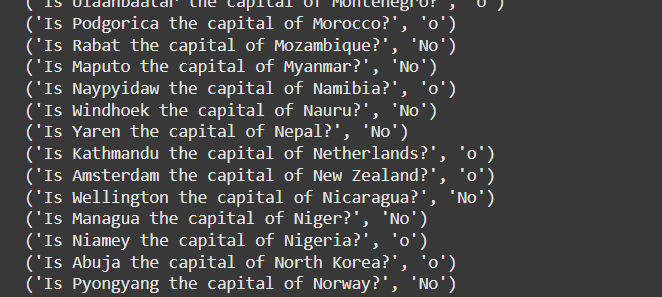

Not sure why it's saying 'o'.  Maybe I limited generation-length too much or something?

Actually, it looks like I may never actually need the responses. But maybe it could be interesting to see whether its wrong answers show anything interesting in activations? (or e.g. do bayesian inference rn to get a confidence)

#imports

In [3]:
import os
import numpy as np
from numpy import dtype
from tqdm.notebook import tqdm
from google.colab import userdata
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from math import exp
import requests
import pickle
import torch
from huggingface_hub import login
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
import sklearn.linear_model
import scipy.stats, scipy.optimize

#model setup

In [2]:
login(token=userdata.get("huggingface_secret"))

device = "cuda" if torch.cuda.is_available() else "cpu"
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

MODEL_NAME = ["meta-llama/Llama-3.1-8B-Instruct", "meta-llama/Llama-3.2-3B-Instruct"][1]
SYS_PROMPT = ""

accelerator = Accelerator()

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    device_map="auto",
    output_hidden_states=True,
    return_dict_in_generate=True,
)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_safetensors=True)
tokenizer.padding_side = "left"
assert str(tokenizer.added_tokens_decoder[128002]) == "<|reserved_special_token_0|>"
tokenizer.pad_token = str(tokenizer.added_tokens_decoder[128002])
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
model, tokenizer = accelerator.prepare(model, tokenizer)

model.generation_config.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# check if the following are necessary etc
model.generation_config.output_hidden_states = True
model.generation_config.return_dict_in_generate = True

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [5]:
def process_chunk(inputs, layer=12, max_new_tokens=5):
    """Returns a structured NumPy array of (("inputs":inputs[0], "responses":responses[0], "states":hidden_states[0]), ...)"""

    def strip_text(text, prompt):
        after_prompt = text[text.index(prompt) + len(prompt) :]
        header = "<|start_header_id|>assistant<|end_header_id|>"
        return after_prompt[after_prompt.index(header) + len(header) :].lstrip()

    if type(inputs) == str:
        print('Please use "[string]" as `text_chunk_batch` (make a singleton list).')
        return False

    conversations = [[{"role": "user", "content": text_chunk}] for text_chunk in inputs]

    prompts = tokenizer.apply_chat_template(conversations, tokenize=False)
    input_tokens = tokenizer(prompts, padding="max_length", padding_side="left", max_length=64, return_tensors="pt")

    with torch.no_grad():
        input_tokens = input_tokens.to(accelerator.device)

        output = model.generate(
            **input_tokens,
            top_k=1,  # always most probable word (rather than softmaxing), as this is all we need for now
            max_new_tokens=max_new_tokens
        )
        # For answering yes/no questions like the following, very low temperature and max_new_tokens makes sense.
        # For this actual task its generations are not actually relevant, but they're helpful to see, and might be useful later.

        sequences, hidden_states = output.sequences, output.hidden_states

        processed_texts = tokenizer.batch_decode(sequences, skip_special_tokens=False) # without capping new_tokens, there might be "<|eot_id|>" at the end
        stripped_texts = [strip_text(text, prompt) for text, prompt in zip(processed_texts, prompts)]
        NUM_ACTIVATIONS = hidden_states[0][layer][0][-1].shape[0]

        return np.array(list(zip(inputs, stripped_texts, np.array([tensor[-1].float().cpu() for tensor in hidden_states[0][layer]]))),
                        dtype=[("inputs", "U10000"), ("responses", "U100"+(max_new_tokens!=5)*"000"), ("states", np.ndarray, (NUM_ACTIVATIONS,))])

# consider returning a "structured ndarray" instead

#simple capitals response collection

In [ ]:
capitals = requests.get("https://raw.githubusercontent.com/JDS289/BaLD4LLM/refs/heads/main/country-list.csv")
capitals_dict = {}
for string in capitals.content.decode('utf-8').split('\n')[1 : -1]:
  _, country, _, city, _ = string.split('"')
  capitals_dict[country] = city

print(capitals_dict)

{'Afghanistan': 'Kabul', 'Albania': 'Tirana', 'Algeria': 'Algiers', 'Andorra': 'Andorra la Vella', 'Angola': 'Luanda', 'Antigua and Barbuda': "St. John's", 'Argentina': 'Buenos Aires', 'Armenia': 'Yerevan', 'Australia': 'Canberra', 'Austria': 'Vienna', 'Azerbaijan': 'Baku', 'Bahamas': 'Nassau', 'Bahrain': 'Manama', 'Bangladesh': 'Dhaka', 'Barbados': 'Bridgetown', 'Belarus': 'Minsk', 'Belgium': 'Brussels', 'Belize': 'Belmopan', 'Benin': 'Porto-Novo', 'Bhutan': 'Thimphu', 'Bosnia and Herzegovina': 'Sarajevo', 'Botswana': 'Gaborone', 'Brazil': 'Brasília', 'Brunei': 'Bandar Seri Begawan', 'Bulgaria': 'Sofia', 'Burkina Faso': 'Ouagadougou', 'Burundi': 'Bujumbura', 'Cambodia': 'Phnom Penh', 'Cameroon': 'Yaoundé', 'Canada': 'Ottawa', 'Cape Verde': 'Praia', 'Central African Republic': 'Bangui', 'Chad': "N'Djamena", 'Chile': 'Santiago', 'China': 'Beijing', 'Colombia': 'Bogotá', 'Comoros': 'Moroni', 'Costa Rica': 'San José', 'Croatia': 'Zagreb', 'Cuba': 'Havana', 'Cyprus': 'Nicosia', "Côte d'Ivo

In [ ]:
MODE = "questions"

if MODE == "statements":
  true_list = [f"{capital} is the capital of {country}." for country, capital in capitals_dict.items()]
  fixed_order_capitals_dict = list(capitals_dict.items())
  false_list = [f"{fixed_order_capitals_dict[i][1]} is the capital of {fixed_order_capitals_dict[(i+1) % len(capitals_dict)][0]}." for i in range(len(capitals_dict))]

  results_true = [(q,) + process_chunk(q) for q in tqdm(true_list)]
  results_false = [(q,) + process_chunk(q) for q in tqdm(false_list)]

elif MODE == "questions":
  true_list = [f"Is {capital} the capital of {country}? (Yes/No) " for country, capital in capitals_dict.items()]
  fixed_order_capitals_dict = list(capitals_dict.items())
  false_list = [f"Is {fixed_order_capitals_dict[i][1]} is the capital of {fixed_order_capitals_dict[(i+1) % len(capitals_dict)][0]}? (Yes/No) " for i in range(len(capitals_dict))]

  def print_return(triple):
    print(triple[:2])
    return triple

  results_true = process_chunk(true_list)
  results_false = process_chunk(false_list)

NameError: name 'process_chunk' is not defined

In [ ]:
want_to_do_this = False

if want_to_do_this:
  statements = []
  responses = []
  hidden_statess = []
  statements_false = []
  responses_false = []
  hidden_statess_false = []


  for s, r, h in results_true:
    statements.append(s)
    responses.append(r)
    hidden_statess.append(h)


  for s, r, h in results_false:
    statements_false.append(s)
    responses_false.append(r)
    hidden_statess_false.append(h)

In [ ]:
# 5 * 29 * 1 * (39 if first-dim = 0 else 1) * 3072  for EACH hidden_statess[i]

# according to https://huggingface.co/docs/transformers/v4.47.0/en/internal/generation_utils#generate-outputs,
# this is probably 5 tokens-generated * 29 layers * 1 batch * (39 | 1) "generated length"   *  3072 activations


# okay yeah 5 is the number of tokens in a typical response, like "<thingyID>assistant\n\nYes"
# prompt has 38 tokens i think, so basically 39?

#Between-Class Ratios Graph

In [83]:
import pickle

with open("/content/drive/My Drive/hidden_statess/true_hidden_statess.pkl", "rb") as f:
  true_hidden_statess = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/false_hidden_statess.pkl", "rb") as f:
  false_hidden_statess = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/hidden_statess/true_hidden_statess.pkl'

In [84]:
between_class_distances = []  # one for each layer
within_class_distances = []  # averaged between True and False; so one for each layer
between_within_ratios = []

for layer_i in range(len(true_hidden_statess[0][0])):
  current_true_average = sum(hidden_states[0][layer_i][0][-1] for hidden_states in true_hidden_statess) / len(true_hidden_statess)
  average_true_distance = sum(torch.norm(current_true_average - hidden_states[0][layer_i][0][-1]) for hidden_states in true_hidden_statess) / len(true_hidden_statess)

  current_false_average = sum(hidden_states[0][layer_i][0][-1] for hidden_states in false_hidden_statess) / len(false_hidden_statess)
  average_false_distance = sum(torch.norm(current_false_average - hidden_states[0][layer_i][0][-1]) for hidden_states in false_hidden_statess) / len(false_hidden_statess)

  between_class_distances.append(torch.norm(current_true_average - current_false_average))
  within_class_distances.append((average_true_distance + average_false_distance) / 2)

  between_within_ratios.append((between_class_distances[-1] / within_class_distances[-1]).item())

NameError: name 'true_hidden_statess' is not defined

In [ ]:
from matplotlib import pyplot as plt

plt.plot(between_within_ratios)

plt.xlabel("Layer number")
plt.ylabel("Between-Class Distance / Within-Class Distance")
plt.title("True-False Separation by Layer")

The "Classes" here are simply {true_statements, false_statements}.

We are using the residual stream activations ($\textbf{r} \in \mathbb{R}^{3072} $) over the final token in input.

Letting $A(s)$ be the activation vector over the final token in input statement $s$, we have, for a layer $l$:


$$\text{trues_center}(l) = \frac{\displaystyle\sum_{s \in \text{true_statements}} {A(s)} }{|\text{true_statements}|} \qquad \qquad \qquad \qquad \quad \text{trues_mean_dist}(l) = \frac{\displaystyle\sum_{s \in \text{true_statements}} {|A(s) - \text{trues_center}(l)|} }{|\text{true_statements}|} \\[0.5in] \text{falses_center}(l) = \frac{\displaystyle\sum_{s \in \text{false_statements}} {A(s)} }{|\text{false_statements}|} \qquad \qquad \qquad \qquad \quad \text{falses_mean_dist}(l) = \frac{\displaystyle\sum_{s \in \text{false_statements}} {|A(s) - \text{falses_center}(l)|} }{|\text{false_statements}|}
\\[0.5in] {\scriptstyle\text{between_class_distance}}(l)=|\text{trues_center}(l)-\text{falses_center}(l)| \qquad  \text{within_class_distance}(l) = \frac{\scriptstyle\text{ trues_mean_dist}+\text{falses_mean_dist}}{2}$$



#Some Analysis of Affirmative Questions

In [ ]:
with open("/content/drive/My Drive/hidden_statess/question_results_true.pkl", "rb") as f:
  results_true = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/question_results_false.pkl", "rb") as f:
  results_false = pickle.load(f)


NUM_ACTIVATIONS = results_true[0][2].shape[0]
results_true_tagged = [result+(True,) for result in results_true]
results_false_tagged = [result+(False,) for result in results_false]

results_structArr = np.array(list(results_true_tagged+results_false_tagged),
                             dtype=[("questions", "U80"), ("responses", "U3"), ("states", np.ndarray, (NUM_ACTIVATIONS,)), ("actual", bool)])
# while the dtype appears as "?", this represents booleans, rather than "unknown"s


assert results_structArr["states"].shape[1] == NUM_ACTIVATIONS

true_positives = results_structArr[(results_structArr["actual"]==True) & (results_structArr["responses"]=="Yes")]
true_negatives = results_structArr[(results_structArr["actual"]==False) & (results_structArr["responses"]=="No")]
false_positives = results_structArr[(results_structArr["actual"]==False) & (results_structArr["responses"]=="Yes")]
false_negatives = results_structArr[(results_structArr["actual"]==True) & (results_structArr["responses"]=="No")]

assert all(r[1] in {"Yes", "No"} for r in results_true+results_false)  # if this starts throwing, consider using .title() and stripping full stops etc


true_average = np.mean(results_structArr[results_structArr['actual']==True]["states"], axis=0)
false_average = np.mean(results_structArr[results_structArr['actual']==False]["states"], axis=0)
truth_direction = true_average - false_average
true_false_center = (true_average + false_average) / 2


def internal_trueness(activations):
    """For either 1d or 2d array `activations`. Can also contain other fields if a structured array with dtype specified as above."""
    if "questions" in repr(activations.dtype):  # if we're using our structured array format, then
        return np.dot(activations["states"]-true_false_center, truth_direction)
    return np.dot(activations-true_false_center, truth_direction)

def mean_trueness(activations):
    """For 2d array `activations`."""
    return float(np.mean(internal_trueness(activations)))

print(f"Average 'Internal Trueness' given true and correct (True Positive): {round(mean_trueness(true_positives), 5)}")
print(f"Average 'Internal Trueness' given true and incorrect (False Negative): {round(mean_trueness(false_negatives), 5)}")
print(f"Average 'Internal Trueness' given false and correct (True Negative): {round(mean_trueness(true_negatives), 5)}")
if len(false_positives):
    print(f"Average 'Internal Trueness' given false and incorrect (False Positive): {round(mean_trueness(false_positives), 5)}")
else:
    print("All false questions identified as such; no False Positives.")
    # This could be in part that the LLM has poorly-calibrated sensitivity/specificity;
    # but also remember that the capitals were simply rotated, so you would expect most of these to be obviously false.

Average 'Internal Trueness' given true and correct (True Positive): 9.02204
Average 'Internal Trueness' given true and incorrect (False Negative): 5.45955
Average 'Internal Trueness' given false and correct (True Negative): -8.43147
All false questions identified as such; no False Positives.


In [ ]:
results_with_trueness = np.zeros(results_structArr.shape, dtype=results_structArr.dtype.descr+[("internal_trueness", float)])
results_with_trueness[list(results_structArr.dtype.names)] = results_structArr
results_with_trueness["internal_trueness"] = internal_trueness(results_with_trueness["states"])

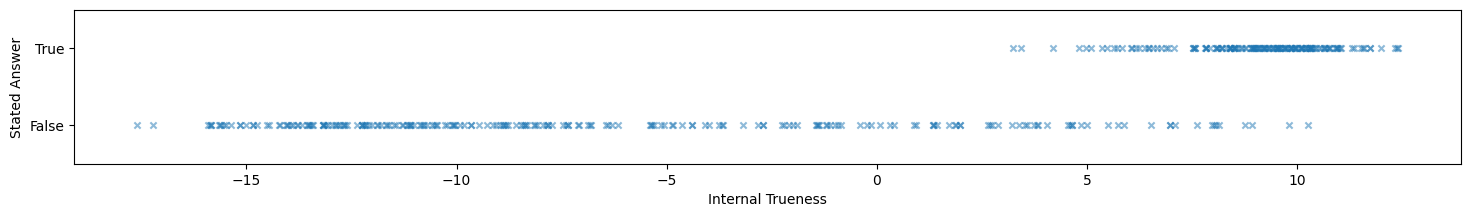

In [ ]:
def scatter(ax, predictions, actual, xlabel="", ylabel="", **kwargs):
    """`predictions` and `actual` should be numpy arrays."""
    ax.scatter(predictions, actual, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_title(f"Correlation: {round(pearsonr(predictions, actual)[0], 6)}", fontsize=10)
    return None  # now ending a Colab code block with scatter(...) avoids an excessive print


fig, ax = plt.subplots(figsize=(17.9, 2))
ax.set_yticks([0, 1], labels=["False", "True"])
ax.set_ylim([-0.5, 1.5])

scatter(ax, results_with_trueness["internal_trueness"], results_with_trueness["answers"]=="Yes", xlabel="Internal Trueness", ylabel="Stated Answer", s=20, marker="x", alpha=0.5)

Now try making a calibrated "answer with confidence" ability from this. Compare this to the actual outputted probabilities.
Hmm okay I've tried to find the "actual outputted probabilities", and while I haven't actually matched up the probabilities with the respective tokens, the probabilities seems suspiciously high, i.e. not calibrated. I could be wrong, but perhaps there is no incentive for an LLM to be calibrated, as "ranking the probabilities" is sufficient for most purposes?

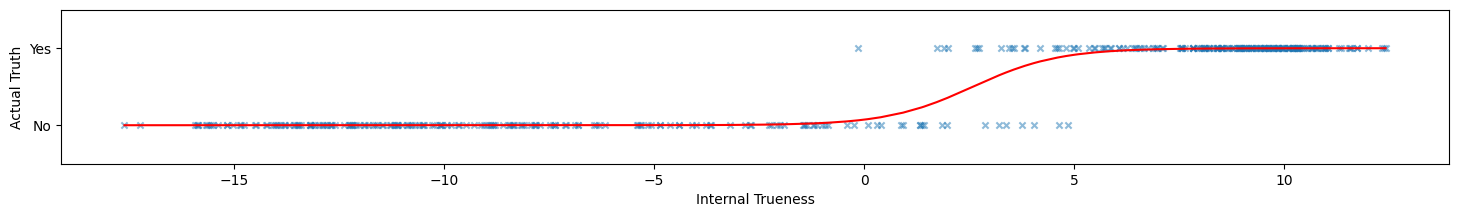

In [ ]:
model = sklearn.linear_model.LogisticRegression()
model.fit(results_with_trueness["internal_trueness"].reshape(-1, 1), results_with_trueness["actual"])


fig, ax = plt.subplots(figsize=(17.9, 2))
ax.set_yticks([0, 1], labels=["No", "Yes"])
ax.set_ylim([-0.5, 1.5])

scatter(ax, results_with_trueness["internal_trueness"], results_with_trueness["actual"], xlabel="Internal Trueness", ylabel="Actual Truth", s=20, marker="x", alpha=0.5)
ax.plot((x:=np.sort(results_with_trueness["internal_trueness"])), model.predict_proba(x.reshape(-1, 1))[:, 1], color="red")

In [ ]:
trueness_when_yes = results_with_trueness[results_with_trueness["actual"]==True]
# results for the questions which should be answered "Yes"

print("Let's look at the questions which should've been answered 'Yes', but with low 'internal trueness'.")
print("For the following such questions, here's the result of Logistic Regression on the Internal Trueness:\n")

for i in trueness_when_yes["internal_trueness"].argsort()[:10]:
    question, answer, _states, _actual, internal_trueness = trueness_when_yes[i]
    print(f"""{question.ljust(80)} -> {answer.ljust(3)} ({round(100*model.predict_proba([[internal_trueness]])[0][1], 1)}%)""")

Let's look at the questions which should've been answered 'Yes', but with low 'internal trueness'.
For the following such questions, here's the result of Logistic Regression on the Internal Trueness:

Is Moroni the capital of Comoros? (Yes/No)                                       -> No  (6.4%)
Is Sanaá the capital of Yemen? (Yes/No)                                          -> No  (30.0%)
Is Georgetown the capital of Guyana? (Yes/No)                                    -> No  (33.5%)
Is Porto-Novo the capital of Benin? (Yes/No)                                     -> No  (35.6%)
Is St. John's the capital of Antigua and Barbuda? (Yes/No)                       -> No  (51.4%)
Is Victoria the capital of Seychelles? (Yes/No)                                  -> No  (52.6%)
Is Tarawa the capital of Kiribati? (Yes/No)                                      -> No  (53.8%)
Is Kingstown the capital of Saint Vincent and the Grenadines? (Yes/No)           -> Yes (65.7%)
Is Vatican City the capital of V

This isn't too bad - by just using Logistic Regression on this linear feature ("trueness"), we could (assuming this isn't much overfitting) allow the LLM to caveat all answers with "x% confidence", such that for this training set all false negatives except one have x <= 70% (note that you should do 100% minus the percentages you see above where the answer is 'No'). So there is only one very confident mistake. What's the LLM thinking?

In [ ]:
print(process_chunk(["Is Moroni the capital of Comoros? "], max_new_tokens=80)[0][1])

No, Moroni is not the capital of Comoros. The capital of Comoros is Moroni is actually the largest city in Comoros, but the capital is actually located on the island of Grande Comore (also known as Ngazidja).<|eot_id|>


Gramatically nonsense, and doesn't make much logical sense either (Moroni *is* located on Ngazidja). Not sure what's up here.

In [ ]:
print(process_chunk(["What is the capital of Comoros? "], max_new_tokens=80)[0][1])

The capital of Comoros is Moroni.<|eot_id|>


But when asked, it said Moroni all out of 5 tries.

In [ ]:
print(process_chunk(["What was Darwin's view of evolution? "], max_new_tokens=80)[0][1])

Charles Darwin's view of evolution is based on his groundbreaking theory of natural selection, which he presented in his book "On the Origin of Species" in 1859. According to Darwin, evolution is a gradual, continuous process that occurs over many generations, driven by the interaction between organisms and their environment.

Here are the key points of Darwin's view of evolution:

1. **


And this looks fine. Weird.

We have no false positives on this set. But let's the other side of the distribution anyway.

In [ ]:
for i in results_with_trueness["internal_trueness"].argsort()[:-40:-1]:
    question, answer, _states, _actual, internal_trueness = trueness_when_yes[i]
    print(f"""{question.ljust(80)} -> {answer.ljust(3)} ({round(100*model.predict_proba([[internal_trueness]])[0][1], 1)}%)""")

Is Kuwait City the capital of Kuwait? (Yes/No)                                   -> Yes (100.0%)
Is Guatemala City the capital of Guatemala? (Yes/No)                             -> Yes (100.0%)
Is Baghdad the capital of Iraq? (Yes/No)                                         -> Yes (100.0%)
Is Phnom Penh the capital of Cambodia? (Yes/No)                                  -> Yes (100.0%)
Is Cairo the capital of Egypt? (Yes/No)                                          -> Yes (100.0%)
Is Bangkok the capital of Thailand? (Yes/No)                                     -> Yes (100.0%)
Is Vilnius the capital of Lithuania? (Yes/No)                                    -> Yes (100.0%)
Is Havana the capital of Cuba? (Yes/No)                                          -> Yes (100.0%)
Is Tirana the capital of Albania? (Yes/No)                                       -> Yes (100.0%)
Is Moscow the capital of Russia? (Yes/No)                                        -> Yes (100.0%)
Is Mexico City the capital of 

Okay, perhaps we *are* overfitting, as these seem unreasonably good. Even so, this is a promising sign! So it's looking like this "giving confidence" idea is potentially reasonable. For now, let's return our focus back to a standard reimplementation of the paper (so, using *statements*, not questions).

#Graph for Affirmative **and** Negated Statements: 2D Subspace

In [63]:
with open("drive/My Drive/capitalsResults2D_8B.pkl", "rb") as f:
    capitalsResults2D = pickle.load(f)

In [5]:
with open("drive/My Drive/capitalsResults2D.pkl", "rb") as f:
    capitalsResults2D = pickle.load(f)

In [87]:
def angle_between(v1, v2):
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

##defining graphing function *plot_separation*

In [99]:
def plot_separation(capitalsResults2D, t_G, t_P):
    states_projected_tagged = np.array([(np.dot(results["states"]-mu_hat, t_G),
                                        np.dot(results["states"]-mu_hat, t_P),
                                        results["actual"], results["polarity"]) for results in capitalsResults2D],
                                dtype=[("G_projection", "f8"), ("P_Projection", "f8"), ("actual", bool), ("polarity", "U11")])

    fig, (ax, ax_other) = plt.subplots(ncols=2, figsize=(11, 5))
    ax.set_xlabel("Projection onto $\mathbf{\hat{t}}_G$")
    ax.set_ylabel("Projection onto $\mathbf{\hat{t}}_P$")

    affirmative_states = states_projected_tagged[states_projected_tagged["polarity"]=="affirmative"]
    negated_states = states_projected_tagged[states_projected_tagged["polarity"]=="negated"]

    ax.scatter(affirmative_states["G_projection"], affirmative_states["P_Projection"], c=affirmative_states["actual"], marker=".")
    ax.scatter(negated_states["G_projection"], negated_states["P_Projection"], c=negated_states["actual"], marker="x")

    ax.set_title(f"My result:")
    ax_other.set_title("The authors' result (on LLaMA3-8B):")

    img = mpimg.imread("drive/MyDrive/affirmativeAndNegated2.png")
    ax_other.imshow(img)
    ax_other.set_axis_off()

##data collection

In [6]:
capitals = requests.get("https://raw.githubusercontent.com/JDS289/BaLD4LLM/refs/heads/main/country-list.csv").content.decode("utf-8").split("\n")[1 : -1]
capitals_dict = {}
for string in capitals:
    _, country, _, city, _ = string.split('"')
    capitals_dict[country] = city
print(capitals_dict)

{'Afghanistan': 'Kabul', 'Albania': 'Tirana', 'Algeria': 'Algiers', 'Andorra': 'Andorra la Vella', 'Angola': 'Luanda', 'Antigua and Barbuda': "St. John's", 'Argentina': 'Buenos Aires', 'Armenia': 'Yerevan', 'Australia': 'Canberra', 'Austria': 'Vienna', 'Azerbaijan': 'Baku', 'Bahamas': 'Nassau', 'Bahrain': 'Manama', 'Bangladesh': 'Dhaka', 'Barbados': 'Bridgetown', 'Belarus': 'Minsk', 'Belgium': 'Brussels', 'Belize': 'Belmopan', 'Benin': 'Porto-Novo', 'Bhutan': 'Thimphu', 'Bosnia and Herzegovina': 'Sarajevo', 'Botswana': 'Gaborone', 'Brazil': 'Brasília', 'Brunei': 'Bandar Seri Begawan', 'Bulgaria': 'Sofia', 'Burkina Faso': 'Ouagadougou', 'Burundi': 'Bujumbura', 'Cambodia': 'Phnom Penh', 'Cameroon': 'Yaoundé', 'Canada': 'Ottawa', 'Cape Verde': 'Praia', 'Central African Republic': 'Bangui', 'Chad': "N'Djamena", 'Chile': 'Santiago', 'China': 'Beijing', 'Colombia': 'Bogotá', 'Comoros': 'Moroni', 'Costa Rica': 'San José', 'Croatia': 'Zagreb', 'Cuba': 'Havana', 'Cyprus': 'Nicosia', "Côte d'Ivo

Given that there were no false positives, we could make the false statements a little more plausible, by swapping the capitals only of bordering countries. For now this seems unnecessary (and potentially non-trivial regarding data collection/matching), and remember that the goal here isn't actually to trip up the LLM - a stronger sense of falseness is not necessarily a bad thing.

In [7]:
country_list = list(capitals_dict.keys())  # I believe dict ordering varies by version of Python

true_affirmatives = [f"{capitals_dict[country]} is the capital of {country}." for country in country_list]
false_negateds = [f"{capitals_dict[country]} is not the capital of {country}." for country in country_list]
true_negateds = [f"{capitals_dict[country]} is not the capital of {country_list[(i+1) % len(country_list)]}." for i, country in enumerate(capitals_dict)]
false_affirmatives = [f"{capitals_dict[country]} is the capital of {country_list[(i+1) % len(country_list)]}." for i, country in enumerate(capitals_dict)]


results_true_affirmative = process_chunk(true_affirmatives)
results_false_negated = process_chunk(false_negateds)
results_true_negated = process_chunk(true_negateds)
results_false_affirmatives = process_chunk(false_affirmatives)

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [8]:
NUM_ACTIVATIONS = results_true_affirmative["states"][0].shape[0]
capitalsResults2D = np.array(sum([[(result["inputs"], result["states"], actual, polarity) for result in results]
                                  for results, actual, polarity in zip([results_true_affirmative, results_false_negated, results_true_negated, results_false_affirmatives],
                                                                       [True, False, True, False],
                                                                       ["affirmative", "negated", "negated", "affirmative"])], []),
                             dtype=[("inputs", "U100"), ("states", np.ndarray, (NUM_ACTIVATIONS,)), ("actual", bool), ("polarity", "U11")])

##trying to manually fit t_G and t_P

In [9]:
NUM_ACTIVATIONS = capitalsResults2D["states"][0].shape[0]
mu_hat = sum(capitalsResults2D["states"]) / len(capitalsResults2D)

capitalsResults2D_lookup = {}
for actual in True, False:
    for polarity in "affirmative", "negated":
        capitalsResults2D_lookup[(actual, polarity)] = capitalsResults2D[(capitalsResults2D["actual"]==actual) & (capitalsResults2D["polarity"]==polarity)]["states"]

def loss(t_G_hat_concat_t_P_hat):
    loss = 0

    assert len(t_G_hat_concat_t_P_hat) == NUM_ACTIVATIONS * 2
    t_G_hat = t_G_hat_concat_t_P_hat[:NUM_ACTIVATIONS]
    t_P_hat = t_G_hat_concat_t_P_hat[NUM_ACTIVATIONS:]

    def approximate_activations(actual, polarity):
        tau = 1 if actual is True else -1
        p = 1 if polarity == "affirmative" else -1

        return mu_hat + tau*t_G_hat + tau*p*t_P_hat

    for actual in True, False:
        for polarity in "affirmative", "negated":
            estimate = approximate_activations(actual, polarity)
            activation_vectors = capitalsResults2D_lookup[actual, polarity]
            loss += np.linalg.norm(activation_vectors - estimate)**2

    print(loss)
    return loss

t_G_hat_concat_t_P_hat = scipy.optimize.least_squares(loss, np.zeros(NUM_ACTIVATIONS*2), max_nfev=1).x
t_G_hat = t_G_hat_concat_t_P_hat[:NUM_ACTIVATIONS]
t_P_hat = t_G_hat_concat_t_P_hat[NUM_ACTIVATIONS:]

4221.434378657692
4221.434378721836
4221.434378908284
4221.434378718664
4221.434378598035
4221.4343785884
4221.434378787297
4221.43437875295
4221.434378812713
4221.4343788145325
4221.434378357838
4221.434378519847
4221.4343783141785
4221.4343784341
4221.434378528422
4221.4343787416565
4221.43437855092
4221.434378627294
4221.434378485457
4221.434378607821
4221.434379053064
4221.4343786872305
4221.434378524864


KeyboardInterrupt: 

This takes far too long. I should think about how they got a "closed-form solution" for this.

##simple fitting

###maths

For now, I'll use something close (or maybe the same? I'm not sure, I should try to prove either way). We want $\mathbf{a} \approx \pmb{\hat{\mu}} + \tau \mathbf{\hat{t}}_G + \tau p \mathbf{\hat{t}}_P$.
Really we have 4 vectors to independently choose, for each $(\tau, p) \in \{-1, 1\}^2$; specifically:

$$\mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P,
\\\mathbf{\hat{t}}_G - \mathbf{\hat{t}}_P,
\\-\mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P,
\\-\mathbf{\hat{t}}_G - \mathbf{\hat{t}}_P$$

So we can independently consider how to fit e.g. the first of these, whose equation would be $ ~ \mathbf{a} \approx \pmb{\hat{\mu}} + \mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P$.

Note that therefore $ ~  \mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P \approx \mathbf{a} - \pmb{\hat{\mu}}$, but crucially there are as many $\mathbf{a}$s as statements in the polarity-actual class (so currently over 100).
Let's just take the average of them for now.

So we choose

$$\mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P = \textbf{average_true_affirmative_activation_vector} - \pmb{\hat{\mu}}
\\\mathbf{\hat{t}}_G - \mathbf{\hat{t}}_P = \textbf{average_true_negated_activation_vector} - \pmb{\hat{\mu}}
\\-\mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P = \textbf{average_false_negated_activation_vector} - \pmb{\hat{\mu}}
\\-\mathbf{\hat{t}}_G - \mathbf{\hat{t}}_P = \textbf{average_false_affirmative_activation_vector} - \pmb{\hat{\mu}} ~$$

so

$$\mathbf{\hat{t}}_G = \textbf{average_true_activation_vector} - \pmb{\hat{\mu}}
\\\mathbf{\hat{t}}_P = \textbf{average__trueAff_or_falseNeg__activation_vector} - \pmb{\hat{\mu}}
\\ $$


I think the other expressions which can be gained are equivalent, not contradictory.

###approximate fitting

In [13]:
NUM_ACTIVATIONS = capitalsResults2D["states"][0].shape[0]
mu_hat = np.mean(capitalsResults2D["states"], axis=0)

t_G = np.mean(capitalsResults2D[capitalsResults2D["actual"]==True]["states"], axis=0) - mu_hat
#t_G /= np.linalg.norm(t_G)
t_P = np.mean(capitalsResults2D[capitalsResults2D["actual"]==((capitalsResults2D["polarity"]=="affirmative"))]["states"], axis=0) - mu_hat
#t_P /= np.linalg.norm(t_P)

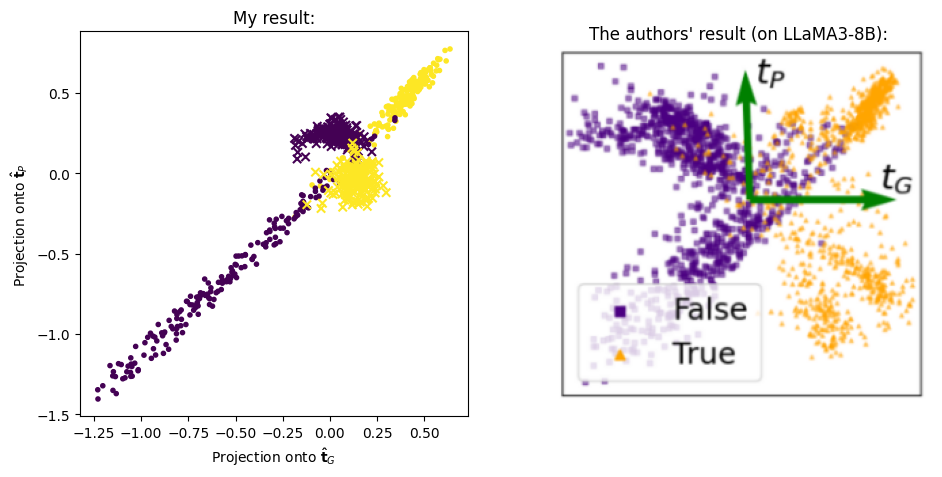

In [96]:
plot_separation(capitalsResults2D)

(currently this is actually for 8B)

Similar, though in my version for 3B, it seems that *negated* statements are consistently "slightly less true-seeming".

It's worth noting that the paper contains many less elegant graphs than that one, e.g.

![a](https://drive.google.com/uc?export=view&id=1-2W_bRg4ffkXS7xdotDXXcQTzdGdxoi2)

##trying a "sum method"

Okay so it looks like my t_G and t_P are not (completely) orthogonal; I think I fit them so that, similar the equation $\mathbf{a} \approx \pmb{\hat{\mu}} + \tau \mathbf{\hat{t}}_G + \tau p \mathbf{\hat{t}}_P$, the actual best-fit coefficients *g* and *p* of $\pmb{\hat{\mu}} + g \mathbf{\hat{t}}_G + p \mathbf{\hat{t}}_P$ would be informative; this is different to projecting $g\mathbf{\hat{t}}_G + p \mathbf{\hat{t}}_P$ along each of the two vectors (when they are not orthogonal).

  0%|          | 0/748 [00:00<?, ?it/s]

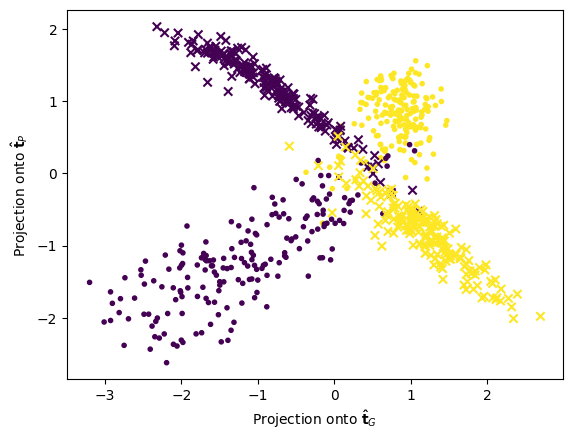

In [81]:
def fit_coefs(states):
    def loss(gp):
        g, p = gp
        return np.linalg.norm(states - mu_hat - g*t_G - p*t_P)

    return tuple(scipy.optimize.minimize(loss, [0, 0]).x)

states_projected_tagged = np.array([fit_coefs(results["states"]) + (results["actual"], results["polarity"]) for results in tqdm(capitalsResults2D)],
                             dtype=[("G_projection", "f8"), ("P_Projection", "f8"), ("actual", bool), ("polarity", "U11")])

fig, ax = plt.subplots()
ax.set_xlabel("Projection onto $\mathbf{\hat{t}}_G$")
ax.set_ylabel("Projection onto $\mathbf{\hat{t}}_P$")

affirmative_states = states_projected_tagged[states_projected_tagged["polarity"]=="affirmative"]
negated_states = states_projected_tagged[states_projected_tagged["polarity"]=="negated"]

ax.scatter(affirmative_states["G_projection"], affirmative_states["P_Projection"], c=affirmative_states["actual"], marker=".")
ax.scatter(negated_states["G_projection"], negated_states["P_Projection"], c=negated_states["actual"], marker="x")

Hmm, not really a fix, and it's hard to work out whether this "sum method" makes sense in 3000 dimensions. What if we just force t_G and t_P to be orthogonal?

maybe useful for 8B i guess?

##separate mean for affirmative and negated

what if the activations store some polarity info, and it just so happens that this info is not orthogonal to the truth direction? this seems plausible, and would result in graphs like mine. let's see what it looks like if we account for this:

###For 3B:

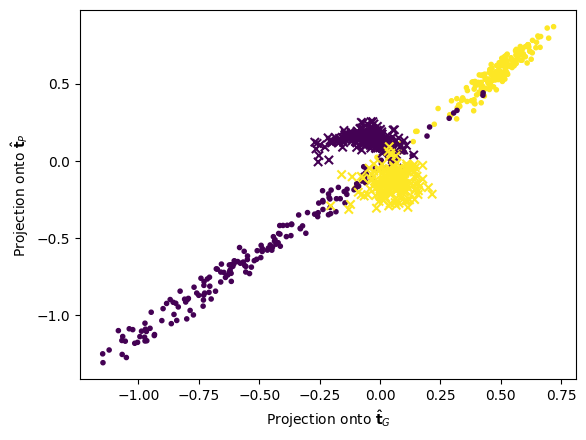

In [23]:
mu_affirmative = np.mean(capitalsResults2D[capitalsResults2D["polarity"]=="affirmative"]["states"], axis=0)
mu_negated = np.mean(capitalsResults2D[capitalsResults2D["polarity"]=="negated"]["states"], axis=0)

varying_mu = np.array([mu_affirmative if results["polarity"]=="affirmative" else mu_negated for results in capitalsResults2D])

states_projected_tagged = np.array(list(zip(np.dot(capitalsResults2D["states"]-varying_mu, t_G),
                                            np.dot(capitalsResults2D["states"]-varying_mu, t_P),
                                            capitalsResults2D["actual"],
                                            capitalsResults2D["polarity"])),
                                   dtype=[("G_projection", "f8"), ("P_Projection", "f8"), ("actual", bool), ("polarity", "U11")])

fig, ax = plt.subplots()
ax.set_xlabel("Projection onto $\mathbf{\hat{t}}_G$")
ax.set_ylabel("Projection onto $\mathbf{\hat{t}}_P$")

affirmative_states = states_projected_tagged[states_projected_tagged["polarity"]=="affirmative"]
negated_states = states_projected_tagged[states_projected_tagged["polarity"]=="negated"]

ax.scatter(affirmative_states["G_projection"], affirmative_states["P_Projection"], c=affirmative_states["actual"], marker=".")
ax.scatter(negated_states["G_projection"], negated_states["P_Projection"], c=negated_states["actual"], marker="x")

###For 8B:

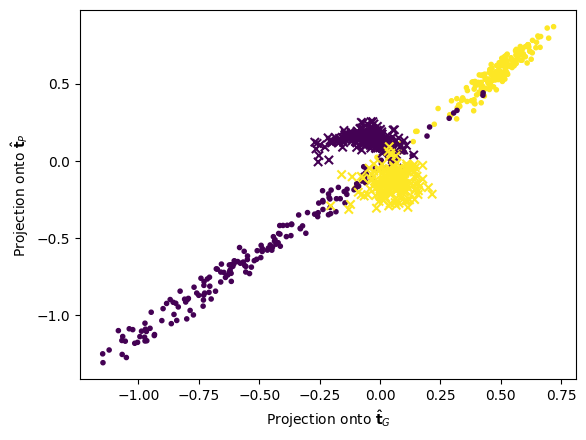

In [64]:
mu_affirmative = np.mean(capitalsResults2D[capitalsResults2D["polarity"]=="affirmative"]["states"], axis=0)
mu_negated = np.mean(capitalsResults2D[capitalsResults2D["polarity"]=="negated"]["states"], axis=0)

varying_mu = np.array([mu_affirmative if results["polarity"]=="affirmative" else mu_negated for results in capitalsResults2D])

states_projected_tagged = np.array(list(zip(np.dot(capitalsResults2D["states"]-varying_mu, t_G),
                                            np.dot(capitalsResults2D["states"]-varying_mu, t_P),
                                            capitalsResults2D["actual"],
                                            capitalsResults2D["polarity"])),
                                   dtype=[("G_projection", "f8"), ("P_Projection", "f8"), ("actual", bool), ("polarity", "U11")])

fig, ax = plt.subplots()
ax.set_xlabel("Projection onto $\mathbf{\hat{t}}_G$")
ax.set_ylabel("Projection onto $\mathbf{\hat{t}}_P$")

affirmative_states = states_projected_tagged[states_projected_tagged["polarity"]=="affirmative"]
negated_states = states_projected_tagged[states_projected_tagged["polarity"]=="negated"]

ax.scatter(affirmative_states["G_projection"], affirmative_states["P_Projection"], c=affirmative_states["actual"], marker=".")
ax.scatter(negated_states["G_projection"], negated_states["P_Projection"], c=negated_states["actual"], marker="x")

weird. the "sum method" looks nicer for this one, but it's concerning that my results seem different to the paper's for the same model.

In [89]:
true_affirmative_average = np.mean(capitalsResults2D[(capitalsResults2D["actual"]==True) & (capitalsResults2D["polarity"]=="affirmative")]["states"], axis=0)
true_negated_average = np.mean(capitalsResults2D[(capitalsResults2D["actual"]==True) & (capitalsResults2D["polarity"]=="negated")]["states"], axis=0)
false_affirmative_average = np.mean(capitalsResults2D[(capitalsResults2D["actual"]==False) & (capitalsResults2D["polarity"]=="affirmative")]["states"], axis=0)
false_negated_average = np.mean(capitalsResults2D[(capitalsResults2D["actual"]==False) & (capitalsResults2D["polarity"]=="negated")]["states"], axis=0)

print(angle_between(true_affirmative_average-false_affirmative_average, t_G) / 3.14)
print(angle_between(true_negated_average-false_negated_average, t_G) / 3.14)

0.13729856199209275
0.42230973713816233


In [90]:
print(np.linalg.norm(true_affirmative_average-false_affirmative_average))
print(np.linalg.norm(true_negated_average-false_negated_average))

2.032801415796219
0.8755723976770855


In [91]:
print(np.linalg.norm(true_affirmative_average-true_negated_average))
print(np.linalg.norm(false_negated_average-false_affirmative_average))

3.905226558753158
4.097429826072228


In [93]:
print(np.linalg.norm(true_affirmative_average-false_negated_average))
print(np.linalg.norm(true_negated_average-false_affirmative_average))

3.877097459198544
4.043295063409904


##TODO: Add more datasets to reduce risk of overfitting.

-

##Ordinary Least Squares (Matrix Form)

###maths

We wish to minimise $\sum \limits_{\text{statements}} ||\mathbf{a} - \pmb{\hat{\mu}} - \tau \mathbf{\hat{t}}_G - \tau p \mathbf{\hat{t}}_P||^2$, where $\mathbf{a}$ is the actual activations for each statement.

Let's substitute in the values of $\tau$ and $p$ by splitting this sum into truth and polarity classes (where e.g. "T&N" means "True and Negated statements"). We thus wish to minimise:

$$~~~~\sum \limits_{\text{T&A}} ||\mathbf{a} - \pmb{\hat{\mu}} -\mathbf{\hat{t}}_G - \mathbf{\hat{t}}_P||^2
\\ + \sum \limits_{\text{T&N}} ||\mathbf{a} - \pmb{\hat{\mu}} - \mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P||^2
\\ + \sum \limits_{\text{F&A}} ||\mathbf{a} - \pmb{\hat{\mu}} + \mathbf{\hat{t}}_G + \mathbf{\hat{t}}_P||^2
\\ + \sum \limits_{\text{F&N}} ||\mathbf{a} - \pmb{\hat{\mu}} + \mathbf{\hat{t}}_G -\mathbf{\hat{t}}_P||^2$$

actually maybe make it actually matrixy by determining tau and p from each statement

In [ ]:
NUM_ACTIVATIONS = capitalsResults2D["states"][0].shape[0]
mu_hat = np.mean(capitalsResults2D["states"], axis=0)

t_G = np.mean(capitalsResults2D[capitalsResults2D["actual"]==True]["states"], axis=0) - mu_hat
t_P = np.mean(capitalsResults2D[capitalsResults2D["actual"]==((capitalsResults2D["polarity"]=="affirmative"))]["states"], axis=0) - mu_hat

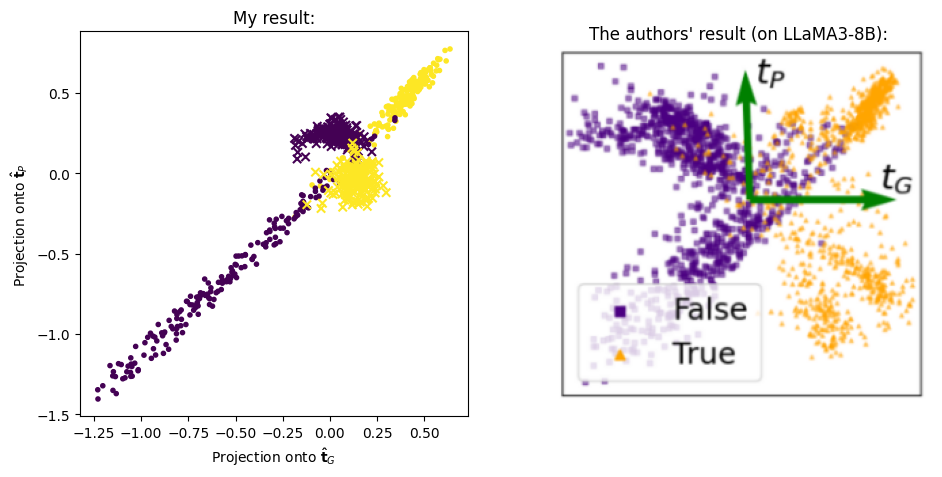

In [100]:
plot_separation(capitalsResults2D, t_G, t_P)